In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn import linear_model

class ExperimentConfig(object):
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


            
def normalized(vec):
    norm = np.linalg.norm(vec, ord=2)
    if norm == 0: return vec
    return vec/norm

def runFeedbackModeling(generateInitialModel, generateData, createModel, updateModel):
    pass

def createFancyClassifier(data, labels):
    model = randomUnitVector(data.shape[1])
    while not np.all(np.sign(data.dot(model)) == np.round(labels)):
        model = randomUnitVector(data.shape[1])
    return model

def createLinearClassifier(data, labels):
    classifier = sklearn.linear_model.RidgeClassifier(alpha=0.0, fit_intercept=False, normalize=False)
    classifier.fit(data, labels)
    return normalized(classifier.coef_.flatten())
    
def randomUnitVector(dim):
    # from https://stackoverflow.com/a/8453514
    vec = np.random.normal(0, 1, [dim])
    while np.linalg.norm(vec, ord=2) == 0: # throw out length zero vectors
        vec = np.random.normal(0, 1, [dim])
    return vec/np.linalg.norm(vec, ord=2) # normalize
    
def linearClassifierLabel(classifier, data, config):
    if data.shape[0] == 0: return [], []
    labels = np.sign(data.dot(classifier))
    n = data.shape[0]
    # for things that are sign zero, randomly assign label
    fixedZeros = np.random.choice(np.array([-1, 1]), n, replace=True)
    labels[labels==0] = fixedZeros[labels==0]
    
    return data, labels
    
def simpleGeneratePoints(n, config):
    return np.random.normal(0, 1, [n,config.dim])


def generateNormalPoints(n, config):
    points = np.random.normal(0, 1, [n, config.dim])
    lens = np.linalg.norm(points, ord=2, axis=1, keepdims=True)
    while not np.all(lens!=0): # reject if any points are length zero (rarely takes more than 1 iter, even for n=10000000)
        points = np.random.normal(0, 1, [n, config.dim])
        lens = np.linalg.norm(points, ord=2, axis=1, keepdims=True)

        
        return points/lens

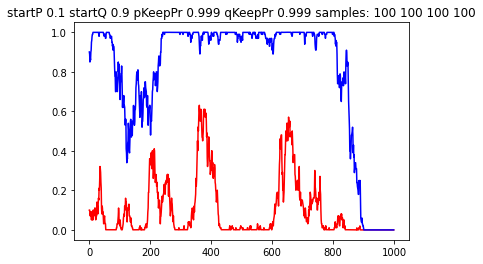

In [27]:
import random
def prFromNSamples(p, n):
    return sum([1 for _ in range(n) if (random.random() < p)])/float(n)

def simpleCoinExperiment(p, q, pKeepPr, qKeepPr, pSamplesForP, pSamplesForQ, qSamplesForQ, qSamplesForP, steps):
    historyP = []
    historyQ = []
    from matplotlib import pyplot as plt
    plt.title(f"startP {p} startQ {q} pKeepPr {pKeepPr} qKeepPr {qKeepPr} samples: {pSamplesForP} {pSamplesForQ} {qSamplesForQ} {qSamplesForP}")
    for _ in range(steps):
        historyP.append(p)
        historyQ.append(q)
        pNew = prFromNSamples(p,pSamplesForP)*pKeepPr + (1-pKeepPr)*prFromNSamples(q, qSamplesForP)
        qNew = prFromNSamples(q,qSamplesForQ)*qKeepPr + (1-qKeepPr)*prFromNSamples(p, pSamplesForQ)
        p, q = pNew, qNew
    plt.plot(historyP, color='r')
    plt.plot(historyQ, color='b')

simpleCoinExperiment(p=0.1, q=0.9, pKeepPr=0.999, qKeepPr=0.999, pSamplesForP=100, pSamplesForQ=100, qSamplesForQ=100, qSamplesForP=100, steps=1000)

In [127]:
import sympy
from sympy import sqrt, pi, gamma, integrate, sin, Sum, binomial, diff
from sympy.abc import f, F, k, w, g, t

n = sympy.symbols("n", real=True, integer=True)

# pdf from https://math.stackexchange.com/a/1248835/155079
gammaStuff = gamma(n/2)/( sqrt(pi)*gamma((n-1)/2)  )
anglePdf = gammaStuff*sin(w)**(n-2)
# by symmetry, we are equally likely to have angle > 90 degrees as we are to have angle < 90 degrees.
# when angle is > 90 degrees, the "angle from the hyperplane" starts to decrease.
# This is a problem for converting to a cdf, because the value gets bigger and then smaller.
# However, as long as we stay within the range of 0-90 degrees (0 to pi/2), it's fine
# Because of that symmetry, if we just multiply our pdf by 2 and restrict our domain then we end up with the correct pdf over angles
pdf = anglePdf*2
# sanity check that integral over the new domain goes to 1: print(integrate(pdf.subs({n: 10}), (w, 0, pi/2)))

# cdf is pdf, integrated from mimimum value (0) to current value (w)
cdf = integrate(pdf.subs({w: t}), (t, 0, w))

# from https://stats.stackexchange.com/a/10072/78563
minValAfterKSamplesCdf = 1-(1-cdf)**k

# convert cdf to pdf by differentiate
minValAfterKSamplesPdf = diff(minValAfterKSamplesCdf, w)

for dim in range(2, 10):
    minValPdf = minValAfterKSamplesPdf.subs({n: dim}).simplify()
    print(dim, minValPdf)
    
    # sanity checks, make sure integrating pdfs over entire range give 1
    #print(integrate(pdf.subs({n: dim}), (w, 0, pi)).simplify())
    #print(integrate(minValAfterKSamplesDimPdf.subs({k: 10}), (w, 0, pi)))
    
    # with n points, we need to consider all assignments of points in top and bottom
    # If we have even number of points in top and bottom, we have
    # integral of w from 0 to pi/2 of w*minValPdf.subs({k: n//2})*minValPdf.subs({k: n//2})
    # 
    #expectedValue = integrate(w*minValPdf, (w, 0, pi/2))
    #print(dim, expectedValue.simplify())
    #res = Sum(binomial(n, k)/2**n*(expectedValue.subs({k: k})+expectedValue.subs({k: (n-k)})), (k, 1, n))
    
    #totalPdf = Sum(binomial(n, k)*minValPdf, (k, 1, n)).doit().expand().simplify()
    #print(dim, minValAfterKSamplesDimPdf)
    
    #print(integrate(minValPdf, (w, 0, pi)).simplify())
    # we need to consider all combinations of points in the top half (labled +) or bottom half (labeled -)
    
    #print(dim, minValPdf)
    #print(totalPdf)
    
'''
2 2*pi**(-k)*k*(pi - 2*w)**(k - 1)
expected value: π/(2 + 2 k)
3 k*sin(w)*cos(w)**(k - 1)
expected value: (sqrt(π) Γ((1 + k)/2))/(k Γ(k/2))
4 4*pi**(-k)*k*(-2*w + 2*sin(w)*cos(w) + pi)**(k - 1)*sin(w)**2
5 3*2**(-k)*k*(-cos(w)**3 + 3*cos(w))**(k - 1)*sin(w)**3
6 16*k*(1/(3*pi))**k*(-6*w + 4*sin(w)**3*cos(w) + 6*sin(w)*cos(w) + 3*pi)**(k - 1)*sin(w)**4
7 15*8**(-k)*k*(3*cos(w)**5 - 10*cos(w)**3 + 15*cos(w))**(k - 1)*sin(w)**5
8 32*k*(1/(5*pi))**k*(-10*w + 16*sin(w)**5*cos(w)/3 + 20*sin(w)**3*cos(w)/3 + 10*sin(w)*cos(w) + 5*pi)**(k - 1)*sin(w)**6
9 35*16**(-k)*k*(-5*cos(w)**7 + 21*cos(w)**5 - 35*cos(w)**3 + 35*cos(w))**(k - 1)*sin(w)**7
'''

2 2*pi**(-k)*k*(pi - 2*w)**(k - 1)
3 k*sin(w)*cos(w)**(k - 1)
4 4*pi**(-k)*k*(-2*w + 2*sin(w)*cos(w) + pi)**(k - 1)*sin(w)**2
5 3*2**(-k)*k*(-cos(w)**3 + 3*cos(w))**(k - 1)*sin(w)**3
6 16*k*(1/(3*pi))**k*(-6*w + 4*sin(w)**3*cos(w) + 6*sin(w)*cos(w) + 3*pi)**(k - 1)*sin(w)**4
7 15*8**(-k)*k*(3*cos(w)**5 - 10*cos(w)**3 + 15*cos(w))**(k - 1)*sin(w)**5
8 32*k*(1/(5*pi))**k*(-10*w + 16*sin(w)**5*cos(w)/3 + 20*sin(w)**3*cos(w)/3 + 10*sin(w)*cos(w) + 5*pi)**(k - 1)*sin(w)**6
9 35*16**(-k)*k*(-5*cos(w)**7 + 21*cos(w)**5 - 35*cos(w)**3 + 35*cos(w))**(k - 1)*sin(w)**7


In [3]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, ord=2)
# from https://stackoverflow.com/a/13849249
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


def doMultiStepClassifierExperiment(n, dim, steps, appendData, ratioTrueAtEachStep, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None):
    config = ExperimentConfig(dim=dim)
    curData, curLabels = [], []
    modelHistory = []
    
    
    if makeInitialModel is None:
        makeInitialModel = randomUnitVector
        
    curModel = makeInitialModel(config.dim)
    originalModel = curModel
    modelHistory.append(originalModel)
    
    pointsCorrect = round(n*ratioTrueAtEachStep)
    pointsNew = n-pointsCorrect
    print("Correct points per step:", pointsCorrect, " New points per step:", pointsNew)
    
    if createData is None:
        createData = generateNormalPoints
    
    if createClassifier is None:
        def createClassifierModel(data, labels):
            return createLinearClassifier(data, labels).flatten()
        createClassifier = createClassifierModel
        
    if labelPoints is None:
        labelPoints = linearClassifierLabel
    
    for t in range(steps):
        stepData = createData(n, config)
        newData, newLabels = labelPoints(curModel, stepData[:pointsNew], config)
        correctData, correctLabels = labelPoints(originalModel, stepData[pointsNew:], config)
        if appendData:
            curData = np.array(list(curData) + list(newData) + list(correctData))
            curLabels = np.array(list(curLabels) + list(newLabels) + list(correctLabels))
        else:
            curData, curLabels = np.array(list(newData) + list(correctData)), np.array(list(newLabels) + list(correctLabels))
        # shuffle the data
        randomPermute = np.arange(curData.shape[0])
        np.random.shuffle(randomPermute)
        curData = curData[randomPermute]
        curLabels = curLabels[randomPermute]
        
        curModel = createClassifier(curData, curLabels)
        modelHistory.append(curModel)
    return modelHistory





def doMultiStepGenerativeExperiment(n, dim, steps, appendData, ratioTrueAtEachStep, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None):
    config = ExperimentConfig(dim=dim)
    curData = []
    modelHistory = []
    
    
    if makeInitialModel is None:
        makeInitialModel = lambda cfg: (0.0, 1.0)
        
    curModel = makeInitialModel(config.dim)
    originalModel = curModel
    modelHistory.append(originalModel)
    
    pointsCorrect = round(n*ratioTrueAtEachStep)
    pointsNew = n-pointsCorrect
    print("Correct points per step:", pointsCorrect, " New points per step:", pointsNew)
    
    if createData is None:
        createData = generateNormalPoints
    
    if createClassifier is None:
        def createClassifierModel(data, labels):
            return createLinearClassifier(data, labels).flatten()
        createClassifier = createClassifierModel
        
    if labelPoints is None:
        labelPoints = linearClassifierLabel
    
    for t in range(steps):
        stepData = createData(n, config)
        newData, newLabels = labelPoints(curModel, stepData[:pointsNew], config)
        correctData, correctLabels = labelPoints(originalModel, stepData[pointsNew:], config)
        if appendData:
            curData = np.array(list(curData) + list(newData) + list(correctData))
            curLabels = np.array(list(curLabels) + list(newLabels) + list(correctLabels))
        else:
            curData, curLabels = np.array(list(newData) + list(correctData)), np.array(list(newLabels) + list(correctLabels))
        # shuffle the data
        randomPermute = np.arange(curData.shape[0])
        np.random.shuffle(randomPermute)
        curData = curData[randomPermute]
        curLabels = curLabels[randomPermute]
        
        curModel = createClassifier(curData, curLabels)
        modelHistory.append(curModel)
    return modelHistory


def doExperiment(n, dim, fancyClassifier=False):
    config = ExperimentConfig(dim=dim, fancyClassifier=fancyClassifier)
    classifier = randomUnitVector(config.dim)
    config.trueClassifier = classifier
    data = generateNormalPoints(n, config)
    if fancyClassifier:
        model = createRandomClassifier(*linearClassifierLabel(classifier, data, config))
    else:
        model = createLinearClassifier(*linearClassifierLabel(classifier, data, config))
    return angle_between(model, config.trueClassifier)

def doExperimentKTimes(k, n, dim, fancyClassifier=False):
    return np.array([doExperiment(n, dim, fancyClassifier=fancyClassifier) for _ in range(k)])


def getStats(k, n, dim, fancyClassifier=False):
    outputs = doExperimentKTimes(k, n, dim, fancyClassifier=fancyClassifier)
    return np.mean(outputs), np.var(outputs)


def getData(k, nPoints, dim):
    print(k, dim)
    from matplotlib import pyplot as plt
    points = [getStats(k, n, dim) for n in nPoints]
    return points

def plotData(k, nPoints, dims):
    datas = [(dim, getData(k, nPoints, dim)) for dim in dims]
    print("k:", k)
    print("Mean:")
    for dim, points in datas:
        plt.plot(nPoints, [x[0] for x in points], label=str(dim) + "D")
    plt.legend()
    plt.show()
    print("Std:")
    for dim, points in datas:
        plt.plot(nPoints, [x[1] for x in points], label=str(dim) + "D")
    plt.legend()
    plt.show()
    return datas


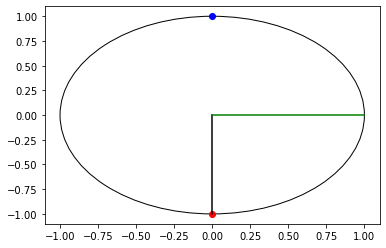

In [97]:
import math
# from https://stackoverflow.com/a/58781388/2924421
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def plotSetup(points, labels):
    classifier = createLinearClassifier(points, labels)
    positivePoints = [points[i] for i in range(points.shape[0]) if labels[i] == 1]
    negativePoints = [points[i] for i in range(points.shape[0]) if labels[i] == -1]
    
    fig, ax = plt.subplots()
    
    ax.plot([p[0] for p in negativePoints], [p[1] for p in negativePoints], 'o', color='b')
    ax.plot([p[0] for p in positivePoints], [p[1] for p in positivePoints], 'o', color='r')
    
    perpendicularAxis = rotate(classifier, degrees=90)
    ax.plot([0, classifier[0]], [0, classifier[1]], color="black")
    ax.plot([0, perpendicularAxis[0]], [0, perpendicularAxis[1]], color="green")
    circle1 = plt.Circle((0, 0), 1.0, color='black', fill=False)
    ax.add_patch(circle1)
    plt.show()

plotSetup(np.array([[0, 1], [0,-1]]), np.array([-1, 1]))

Correct points per step: 10  New points per step: 990


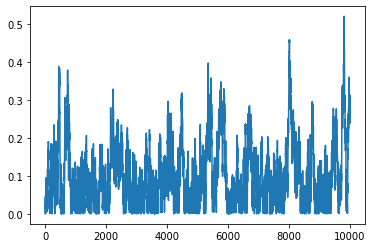

In [73]:
history = doMultiStepClassifierExperiment(n=1000, dim=2, steps=10000, appendData=False, ratioTrueAtEachStep=0.01, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

Correct points per step: 10  New points per step: 990


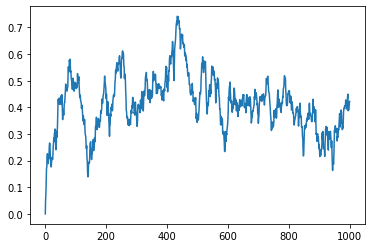

In [4]:
history = doMultiStepClassifierExperiment(n=1000, dim=10, steps=1000, appendData=False, ratioTrueAtEachStep=0.01, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

Correct points per step: 0  New points per step: 1000


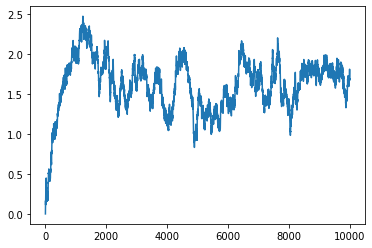

In [30]:
history = doMultiStepClassifierExperiment(n=1000, dim=10, steps=10000, appendData=False, ratioTrueAtEachStep=0.0, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

Correct points per step: 12  New points per step: 3988


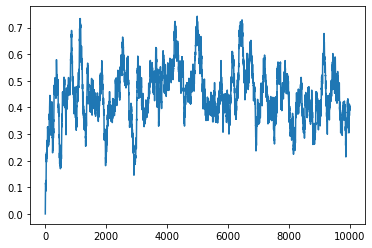

In [35]:
history = doMultiStepClassifierExperiment(n=4000, dim=10, steps=10000, appendData=False, ratioTrueAtEachStep=0.003, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

Correct points per step: 3  New points per step: 997


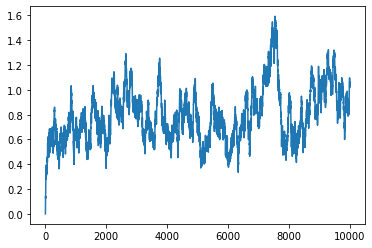

In [34]:
history = doMultiStepClassifierExperiment(n=1000, dim=10, steps=10000, appendData=False, ratioTrueAtEachStep=0.003, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

In [ ]:
history = doMultiStepClassifierExperiment(n=1000, dim=2, steps=10000, appendData=False, ratioTrueAtEachStep=0.0, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

Correct points per step: 0  New points per step: 1000


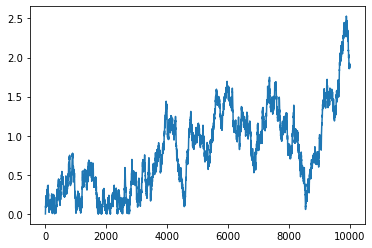

In [27]:
history = doMultiStepClassifierExperiment(n=1000, dim=2, steps=10000, appendData=False, ratioTrueAtEachStep=0.0, makeInitialModel=None, createData=None, createClassifier=None, labelPoints=None)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

In [198]:
config = ExperimentConfig(dim=2)
newData = simpleGeneratePoints(10, config)
[x for x in newData] + [x for x in newData]

[array([-0.06012418,  1.66233942]),
 array([-0.27125289, -1.1451496 ]),
 array([-1.30193581, -1.3825252 ]),
 array([0.205162  , 1.13318918]),
 array([0.12933635, 1.58011963]),
 array([1.45161821, 0.05066223]),
 array([0.8461988 , 0.41944051]),
 array([-1.38341243,  1.78269953]),
 array([ 0.50209121, -0.06374071]),
 array([ 0.99778547, -0.48085415]),
 array([-0.06012418,  1.66233942]),
 array([-0.27125289, -1.1451496 ]),
 array([-1.30193581, -1.3825252 ]),
 array([0.205162  , 1.13318918]),
 array([0.12933635, 1.58011963]),
 array([1.45161821, 0.05066223]),
 array([0.8461988 , 0.41944051]),
 array([-1.38341243,  1.78269953]),
 array([ 0.50209121, -0.06374071]),
 array([ 0.99778547, -0.48085415])]

In [210]:
history = doMultiStepExperiment(n=1000, dim=2, steps=10000, appendData=False)


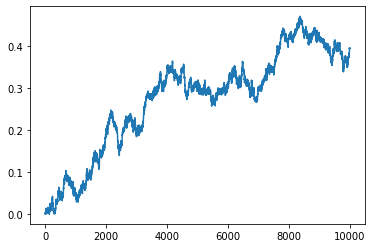

In [217]:
history = doMultiStepExperiment(n=100000, dim=2, steps=10000, appendData=False)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

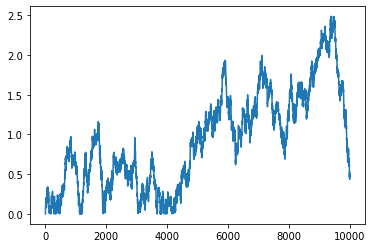

In [211]:
history = doMultiStepExperiment(n=1000, dim=2, steps=10000, appendData=False)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

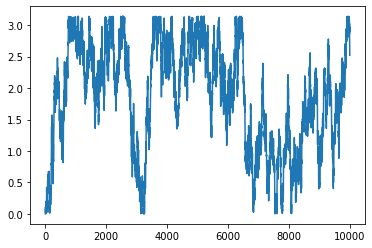

In [209]:
history = doMultiStepExperiment(n=100, dim=2, steps=10000, appendData=False)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

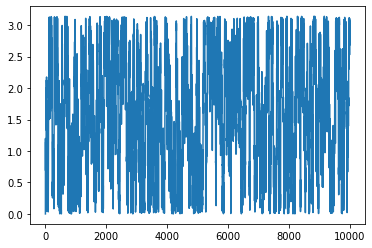

In [207]:
history = doMultiStepExperiment(n=10, dim=2, steps=10000, appendData=False)
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

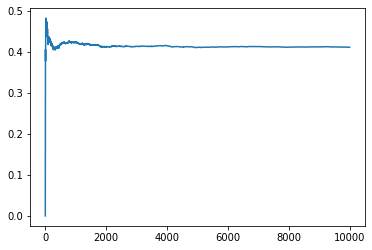

In [205]:
angles = [angle_between(history[0], history[i]) for i in range(len(history))]
from matplotlib import pyplot as plt
plt.plot(angles)
plt.show()

In [238]:
def findNThresh(k, meanThresh, dim):
    curN = 2
    while True:
        curN += 1
        mu, var = getStats(k=k, n=curN, dim=dim)
        if curN % 10 == 0: print(curN, mu, var)
        if mu < meanThresh: return curN

findNThresh(100, 0.1, 2)
    
    



10 0.20030538839913656 0.02468604180329912
20 0.14466961642716844 0.010136135632825567
30 0.11510389903499464 0.005363101081865686


33

In [18]:
getStats(k=10000, n=5, dim=2, fancyClassifier=True)

(0.3527557592031955, 0.11553403105274869)

In [288]:
getStats(k=1000, n=round(10*2**(6*1.39)), dim=2*2**6)

(0.15125684277623025, 9.734091796503635e-05)

In [232]:

findNThresh(100, 0.1, 3)

3 0.9563685551500014 0.44158475489078236
4 0.6321622114720131 0.23111055253217128
5 0.5427809922481703 0.12745555761934685
6 0.45283280117616537 0.11347081577080059
7 0.39935956022813146 0.045729039918254444
8 0.40154555383851753 0.12071046775689184
9 0.3896113235959809 0.10446286402971362
10 0.33251825472324753 0.036880457994705906
11 0.3134523926422409 0.026231509902862715
12 0.2972037758998385 0.031138887854428834
13 0.28477478996996375 0.028150028680515
14 0.24310984691964 0.019368750330774842
15 0.25700309933511006 0.02003226178137743
16 0.23306382532366915 0.016359162799061494
17 0.2314871956340915 0.01566041684967836
18 0.24048635486288877 0.020770586069013053
19 0.21559053467909298 0.014673625437753803
20 0.2213816275642527 0.015516657685511893
21 0.19274193864931333 0.013160047505063983
22 0.21851909475023376 0.011661543266408145
23 0.20993570691078564 0.01447294333643858
24 0.2017634756050755 0.009837534390889016
25 0.20504339404253855 0.014705886168245452
26 0.19023564240638

83

In [ ]:
getStats(k=5000, n=1000, dim=100)

In [235]:
datas[0]

(2,
 [(0.10662685490807236, 0.006957649709063999),
  (0.09869588738211106, 0.005593793993413713),
  (0.084959575013748, 0.00479764278480261),
  (0.08278872394800517, 0.0032451832439507277),
  (0.07196452173143027, 0.004108929700557273),
  (0.0641447987696083, 0.002220884790673568),
  (0.06308058402409712, 0.0024226524225410494),
  (0.055413827097527575, 0.0016195408652630277),
  (0.04419801360699609, 0.0010470897263404144),
  (0.043130995433505806, 0.0010347829544511142),
  (0.04172637947805993, 0.0008365999907574119),
  (0.03607461772085004, 0.0006000088038950075),
  (0.033983116549242964, 0.0007284925110461462),
  (0.03196002156330765, 0.0006565093247415571),
  (0.026641313592072766, 0.0004701354889040583),
  (0.030054573365674894, 0.0005837830512640241),
  (0.02793947259170569, 0.000612641674903535),
  (0.022137413019527125, 0.0003514337520802076),
  (0.026084660194864752, 0.0004684899492237621),
  (0.024093959923182296, 0.0003633761637928132),
  (0.021236928511223146, 0.00029745687

In [249]:
mus = np.linspace(1.0,0.1, 10)
nPts = [x**2 for x in range(5, 100)]
for muUpperBound in mus:
    print(muUpperBound)
    for t, data in datas:
        for i in range(len(data)):
            mu, std, n = data[i][0], data[i][1], nPts[i]
            if mu < muUpperBound:
                print(t, n, mu, muUpperBound)
                break
    

1.0
2 25 0.13890509675640328 1.0
4 25 0.254099804228447 1.0
8 25 0.42217778106588705 1.0
16 25 0.6901528784107052 1.0
32 25 0.9602090652069332 1.0
64 81 0.8889108732584157 1.0
128 169 0.8874699543552339 1.0
0.9
2 25 0.13890509675640328 0.9
4 25 0.254099804228447 0.9
8 25 0.42217778106588705 0.9
16 25 0.6901528784107052 0.9
32 49 0.7259079436003684 0.9
64 81 0.8889108732584157 0.9
128 169 0.8874699543552339 0.9
0.8
2 25 0.13890509675640328 0.8
4 25 0.254099804228447 0.8
8 25 0.42217778106588705 0.8
16 25 0.6901528784107052 0.8
32 49 0.7259079436003684 0.8
64 100 0.7580273505483089 0.8
128 196 0.7859437786110225 0.8
0.7
2 25 0.13890509675640328 0.7
4 25 0.254099804228447 0.7
8 25 0.42217778106588705 0.7
16 25 0.6901528784107052 0.7
32 64 0.6264752356407964 0.7
64 121 0.6721985359187453 0.7
128 225 0.6977198974605616 0.7
0.6
2 25 0.13890509675640328 0.6
4 25 0.254099804228447 0.6
8 25 0.42217778106588705 0.6
16 36 0.5499798815543208 0.6
32 81 0.523505254954125 0.6
64 144 0.583662718179821

In [242]:
datas = plotData(nPoints=[x**2 for x in range(5, 100)], k=100, dims=[2,4,8,16,32,64,128])

100 2
100 4


KeyboardInterrupt: 

In [234]:
datas = plotData(nPoints=range(5, 50), k=1000, dims=[2,4,8,16,32,64])

1000 2


KeyboardInterrupt: 

In [123]:
plotData(nPoints=range(5, 60), k=4000, dim=3)

KeyboardInterrupt: 

In [104]:
for x in [(np.arange(2, 100)[i], points[i][0]) for i in range(len(points))[:30:2]]: print(str(x[0]) + "\t" + str(x[1]))

2	1.1053940362873402
4	0.4788795875306333
6	0.32206561429947705
8	0.25330416896505226
10	0.21013379862571385
12	0.18667486476860073
14	0.16935689370682813
16	0.16231350794647964
18	0.1532824694353244
20	0.14142410387220605
22	0.13263648596871233
24	0.13096176826815656
26	0.11928926701844328
28	0.11821742175762108
30	0.11835410583601091


In [73]:
# for 10,2
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(3.139414061749976,
 6.364034564513857e-07,
 0.033641723685152856,
 0.20659318136447652)

In [76]:
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(3.1410524038164094,
 8.53839136957796e-06,
 0.03326353526691698,
 0.2071890110161472)

In [81]:
# for 100,2
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(0.3049976893764085,
 1.2129453681046834e-05,
 0.002157852516562221,
 0.06086964407600777)

In [83]:
# for 100,2
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(0.3469005401222243,
 1.307543568385954e-05,
 0.002132078613195565,
 0.06097777549264636)

In [88]:
# for 200,2
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(0.2338473355744885,
 4.0920444458277605e-06,
 0.001064930255961753,
 0.04244033273715284)

In [85]:
# for 200,2
np.max(outputs), np.min(outputs), np.var(outputs), np.mean(outputs)

(0.2418970017252851,
 1.4863473200602115e-05,
 0.0010447902739469503,
 0.04294535601949977)

In [79]:
angle_between(np.array([1,0]), np.array([0,1]))

1.5707963267948966

In [1]:
import markovify

In [40]:
import markovify

BEGIN_TOKEN = "___BEGIN__"

def generateStartToEndText(model, maxLen=-1):
    '''
    Uses the given markov chain to generate a sentence
    Returns (totalScore, madeSentence)
    where totalScore is the sum of the path probabilities
    '''
    modelGen = model.chain.gen()
    state_size = model.chain.state_size
    context = [BEGIN_TOKEN]*state_size
    madeSentence = []
    #totalScore = 0
    for curWord in modelGen:
        madeSentence.append(curWord)
        #totalScore += model.chain.model[tuple(context)][curWord]
        context.pop(0)
        context.append(curWord)
        # early bail if we are long enough
        if maxLen > -1 and len(madeSentence) >= maxLen: break
    return madeSentence


def generateTextOfLen(model, textLen):
    '''
    Generates text of the given length
    If the model hits the end token, this jumps back to
    the start token and continues generating until the combined
    sequences are long enough
    '''
    resultSent = generateStartToEndText(model, textLen)
    while len(resultSent) < textLen:
        resultSent += generateStartToEndText(model, textLen-len(resultSent))
    return " ".join(resultSent[:textLen])


def generateDataset(model, sampleLen, numSamples):
    '''
    Generates numSamples of text from the given markov chain,
    where each sample is of length sampleLen
    When generating an individual sample, if it hits the end token,
    it hops back to the start token to continue generating the sample
    '''
    return "\n".join([generateTextOfLen(model, sampleLen) for _ in range(numSamples)])
    
    

'''
totalScore = 0
numWords = 1
for curWord in modelGen:
    madeSentence.append(curWord)
    numWords += 1
    totalScore += model.chain.model[(prevPrevWord, prevWord,)][curWord]
    prevPrevWord = prevWord
    prevWord = curWord
len(madeSentence), model.chain.state_size
'''

def runExperiment(initialDataset, numSteps, stateSize, sampleLen, numSamples):
    model = markovify.Text(initialDataset, state_size=stateSize)
    models = []
    for t in range(numSteps):
        models.append(model)
        dataset = generateDataset(model, 10, 10)
        model = markovify.Text(dataset, state_size=stateSize)
    return models

def loopThroughEdgeCounts(model):
    '''
    # model chain stores counts as chain.model[(tuple, of, context)][nextWord]
    # so we need to connect edges between (tuple, of, context) and (of, context, nextWord)
    # so this loops through and returns each
    (tuple, of, context), (of, context, nextWord), transitionCount
    '''
    for keyTuple, outputDict in model.chain.model.items():
        keyTupleList = list(keyTuple)
        for outputNode, transitionPr in outputDict.items():
            connectToNodeList = keyTupleList[1:] + [outputNode]
            yield (keyTuple, tuple(connectToNodeList), transitionPr)

import graphviz
def modelToDot(model):
    dot = graphviz.Digraph()
    # it stores probabilities as chain.model[(tuple, of, context)][nextWord]
    # so we need to connect edges between (tuple, of, context) and (of, context, nextWord)
    # made utility function loopThroughEdgeCounts that loops through these for us
    for keyTuple, outputDict in model.chain.model.items():
        dot.node(" ".join(list(keyTuple)))
    for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
        dot.edge(" ".join(tupleIn), " ".join(tupleOut), label=str(transitionCount))
    return dot

def modelHistoryToGraphs(modelHistory):
    edges = dict()
    # loop through all models and get all edges
    for model in modelHistory:
        for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
            edge = (tupleIn, tupleOut)
            if not edge in edges:
                edges[edge] = []
    
    # for each edge, construct a history graph of transition counts
    for model in modelHistory:
        # append a zero to the end of every pair, this ensures if our model doesn't have it it still gets noted
        for edge, arr in edges.items():
            arr.append(0)
        # for every pair our model has, overwrite those zeros at the end with the actual transition count
        for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
            edge = (tupleIn, tupleOut)
            # overwrite last value to our transition count
            edges[edge][-1] = transitionCount
    return edges

from matplotlib import pyplot as plt
def printModelHistoryAsGraphs(modelHistory):
    graphs = modelHistoryToGraphs(modelHistory)
    for edgeTuple, historyOfCounts in graphs.items():
        plt.plot(historyOfCounts)
        plt.title(str(edgeTuple))
        plt.show()
        

from IPython.display import display
def runAndVisualizeExperiment(initialDataset, printRange, numSteps, stateSize, sampleLen, numSamples):
    modelHistory = runExperiment(initialDataset=initialDataset, numSteps=numSteps, stateSize=stateSize, sampleLen=sampleLen, numSamples=numSamples)
    for i in printRange:
        print(i, "model:")
        display(modelToDot(modelHistory[i]))
        print(generateTextOfLen(modelHistory[i], textLen=100))
    printModelHistoryAsGraphs(modelHistory)
    #return modelHistory
    


0 model:


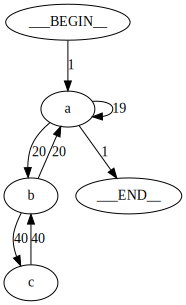

a a a a b c b c b c b c b c b a a b c b c b a b a b a b a a a a b c b a b a a a a a b c b a a a b c b c b c b c b a b c b c b a a a b a b c b c b c b c b c b a b c b c b c b a a b c b c b c b a b c b
-1 model:


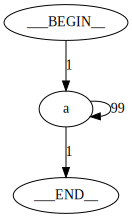

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


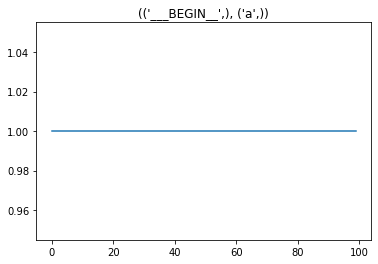

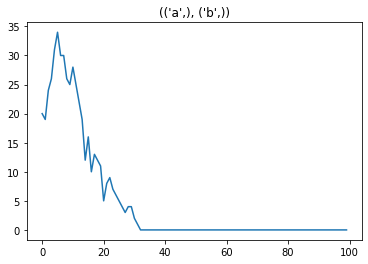

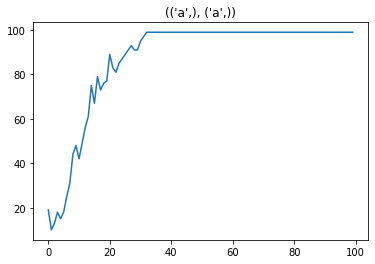

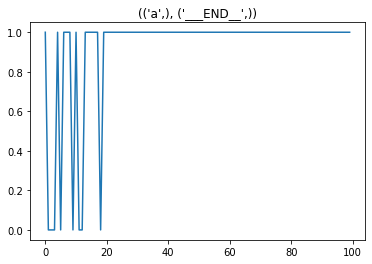

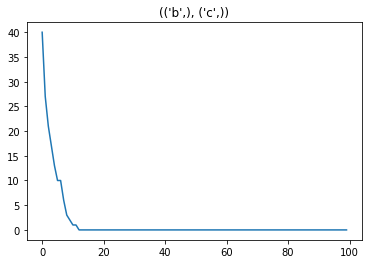

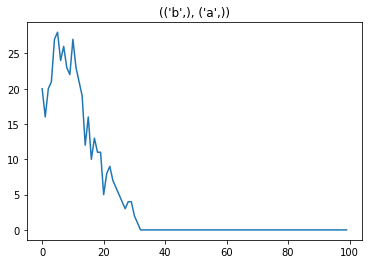

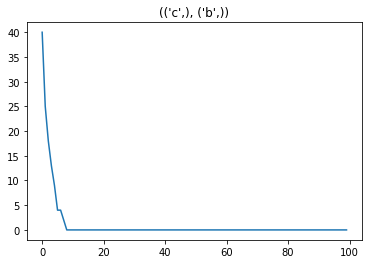

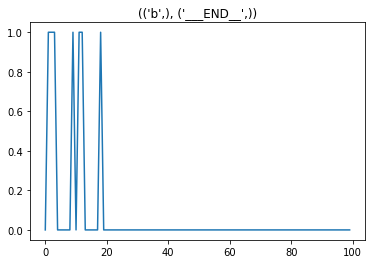

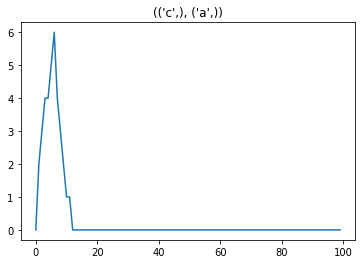

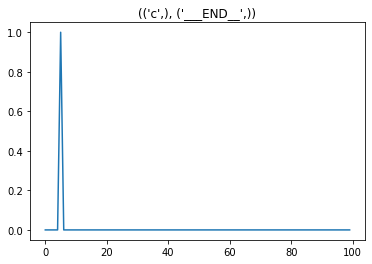

In [45]:

text = (("a b c b c b a "*2) + "\n")*10
numSteps=10
models = runAndVisualizeExperiment(initialDataset=text, printRange=[0,-1], numSteps=100, stateSize=1, sampleLen=100, numSamples=100)

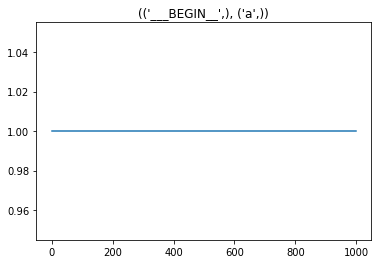

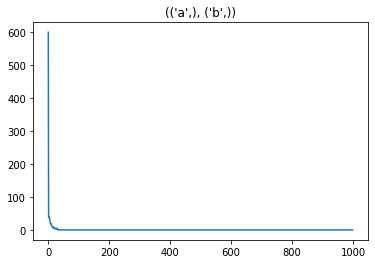

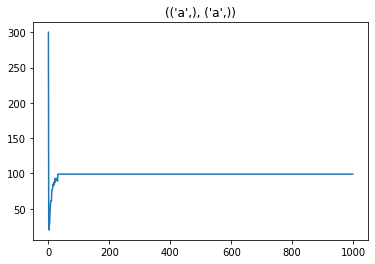

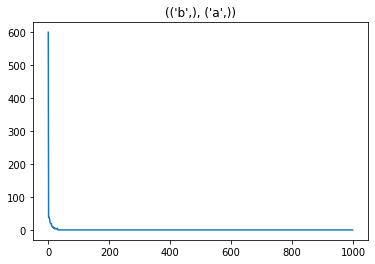

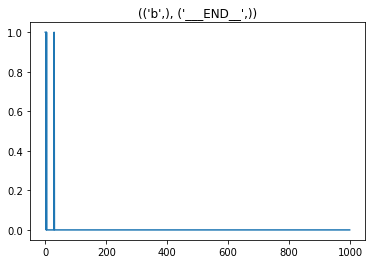

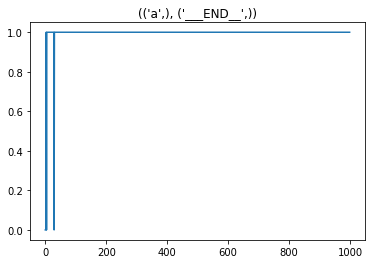

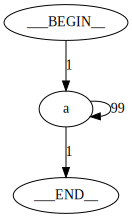

In [4]:
visualizeModel(models[-1].chain)